In [ ]:
!pip install opencv-python

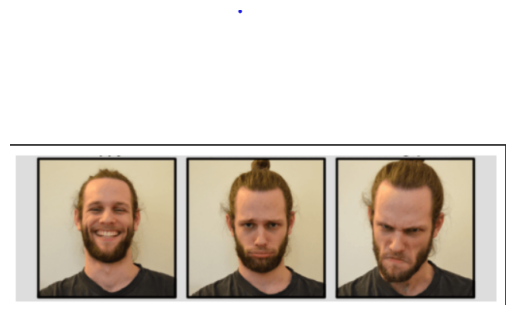

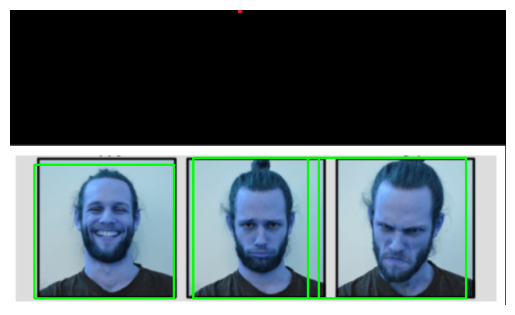

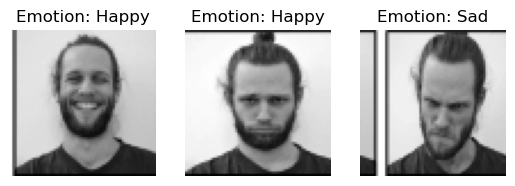

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the PNG image with an alpha channel
image_path = r"image.png"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Display the image, considering the alpha channel
plt.imshow(image)
plt.axis('off')
plt.show()

# Remove alpha channel from the image
image = image[:, :, :3]  # Keep only the first three channels (RGB)

# Get the dimensions of the input image
height, width, _ = image.shape

# Load the pre-trained YOLO weights and configuration file
yolo_net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
layer_names = yolo_net.getUnconnectedOutLayersNames()

# Perform YOLO inference
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
yolo_net.setInput(blob)
outs = yolo_net.forward(layer_names)

# Extract and preprocess detected faces
detected_faces = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > 0.5 and class_id == 0:  # Assuming class_id 0 corresponds to a person's face
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Calculate bounding box coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            # Extract the face
            face = image[y:y+h, x:x+w]

            # Append the detected face and its bounding box to the list
            detected_faces.append((x, y, w, h, face))

# Load the trained emotion classification model
emotion_model = load_model('fer2013_mini_XCEPTION.102-0.66.hdf5')  # Replace with the actual path to your model

# Emotion labels
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Display the original image with bounding boxes around detected faces
image_with_boxes = image.copy()

for (x, y, w, h, _) in detected_faces[:3]:  # Display only the first 3 faces
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Display each detected face separately with emotion prediction
for i, (x, y, w, h, face) in enumerate(detected_faces[:3]):  # Process only the first 3 faces
    # Preprocess the face image (resize it to match the input size of your CNN)
    resized_face = cv2.resize(face, (64, 64))  # Assuming input size of the emotion model is 64x64
    resized_face_gray = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_face_gray = resized_face_gray / 255.0  # Normalize pixel values to the range [0, 1]
    resized_face_gray = np.expand_dims(resized_face_gray, axis=-1)  # Add channel dimension

    # Perform emotion prediction
    emotion_probabilities = emotion_model.predict(np.expand_dims(resized_face_gray, axis=0))
    predicted_emotion_index = np.argmax(emotion_probabilities)
    predicted_emotion_label = emotion_labels.get(predicted_emotion_index, "Unknown")

    # Display the face with emotion prediction using resized_face_gray instead of resized_face
    plt.subplot(1, len(detected_faces[:3]), i + 1)
    plt.imshow(resized_face_gray.squeeze(), cmap='gray')  # Use resized_face_gray instead of resized_face
    plt.axis('off')
    plt.title(f"Emotion: {predicted_emotion_label}")

plt.show()